<a href="https://colab.research.google.com/github/rdkdaniel/Computer-Vision/blob/main/Cancer_Detection_(CTCs).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Key links: https://towardsdatascience.com/convolutional-neural-network-for-breast-cancer-classification-52f1213dcc9

https://python.plainenglish.io/skin-cancer-detection-using-convolutional-neural-networks-38f386cdc6d7

# **1. Skin Cancer**

**Libraries**

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from glob import glob
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D

**The Data**

In [ ]:
#https://www.kaggle.com/datasets/nodoubttome/skin-cancer9-classesisic?resource=download

In [2]:
#Connecting colab with kaggle to get the data
#Install the Kaggle library
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
#Make a directory named “.kaggle”
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [9]:
#Copy the “kaggle.json” into this new directory
! cp kaggle.json ~/.kaggle/

In [10]:
#Allocate the required permission for this file
! chmod 600 ~/.kaggle/kaggle.json

In [11]:
#Downloading dataset
! kaggle datasets download nodoubttome/skin-cancer9-classesisic

 99% 778M/786M [00:09<00:00, 88.8MB/s]
100% 786M/786M [00:09<00:00, 87.0MB/s]


**Unzipping the dataset**

In [14]:
!unzip skin-cancer9-classesisic.zip

Archive:  skin-cancer9-classesisic.zip
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024511.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024646.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024654.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024707.jpg  
  inflating: Skin cancer 

After unzipping the dowloaded dataset, the entire dataset, (now as a folder) were available on the Colab File section on the left.

Expanding the folder holding this dataset, would reveal the two splits i.e. Train and Test folder.

It is these subsequent folders that now are specified in the next section of code

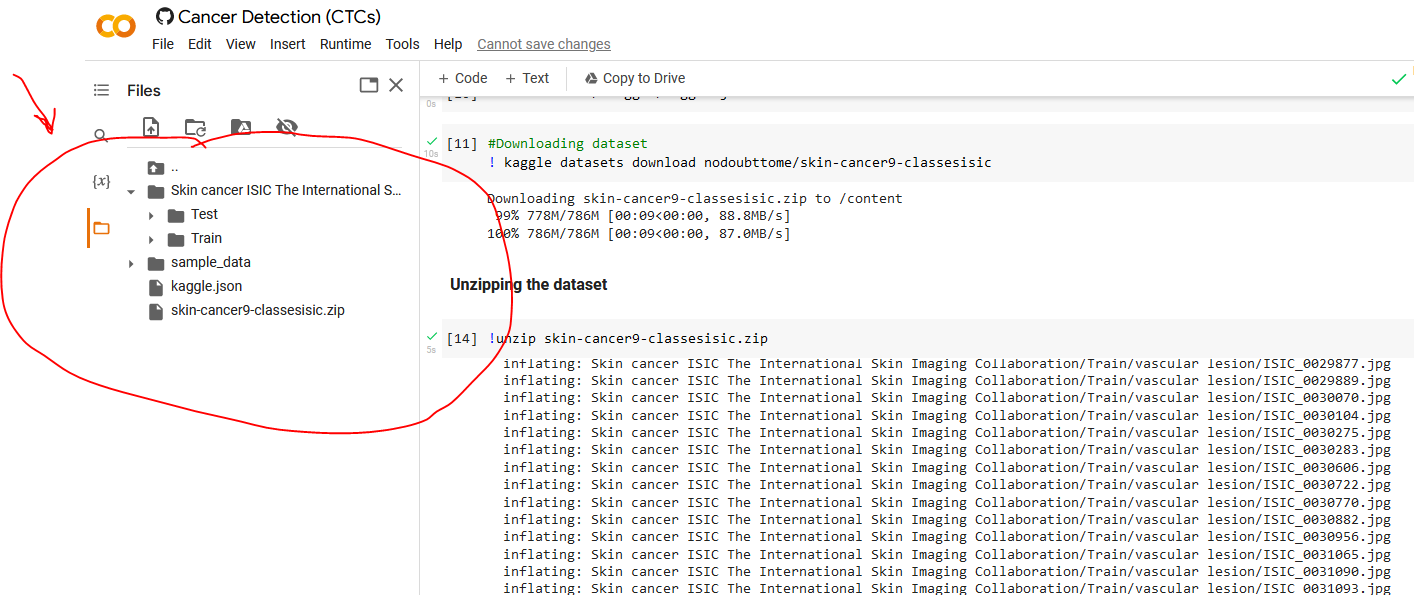

**Define path for train and test images**

In [15]:
train_path="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
test_path="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test"
data_dir_train = pathlib.Path(train_path)
data_dir_test = pathlib.Path(test_path)

In [16]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


# **Data Preparation**

In [18]:
batch_size = 32
img_height = 180
img_width = 180

**Train Data Set Creation** 

In [19]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, labels='inferred', label_mode='categorical',
    class_names=None, color_mode='rgb', batch_size=32, image_size=(180,
    180), shuffle=True, seed=123, validation_split=0.2, subset='training',
    interpolation='bilinear', follow_links=False, smart_resize=False
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


**Validation Data Set Creation**

In [20]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, labels='inferred', label_mode='categorical',
    class_names=None, color_mode='rgb', batch_size=32, image_size=(180,
    180), shuffle=True, seed=123, validation_split=0.2, subset='validation',
    interpolation='bilinear', follow_links=False, smart_resize=False
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [21]:
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


# **Visualizing the data**

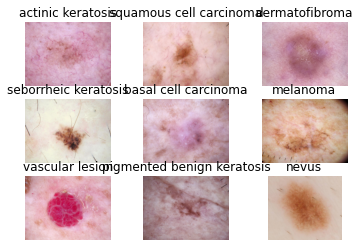

In [22]:
import matplotlib.pyplot as plt
num=0
for dirpath, dirnames, filenames in os.walk(str(train_path)):
    for filename in [f for f in filenames if f.endswith(".jpg")][:1]:
        img = PIL.Image.open(str(dirpath)+"/"+str(filename))
        plt.subplot(3,3,num+1)
        plt.title(str(dirpath).split('/')[-1])
        plt.axis('off')
        plt.imshow(img)
        num=num+1

The image_batch is a tensor of the shape (32, 180, 180, 3). 

This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

Dataset.prefetch() overlaps data preprocessing and model execution while training.


In [23]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# **The Models**

# **Model 1**

**1.0 Creating model 1**

In [24]:
model=Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255., offset=0.0,),         
    
    Conv2D(32,(3,3),input_shape=(img_height,img_width,3),activation='relu',padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.1),
    
    Conv2D(64,(3,3),activation='relu',padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.1),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.25),   
    Dense(9, activation='softmax')
])

**1.1 Compiling the model**

In [25]:
### Choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

**1.2 Training the model**

In [26]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 72s 1s/step - loss: 3.1443 - accuracy: 0.2176 - val_loss: 1.9739 - val_accuracy: 0.3356
Epoch 2/20
56/56 [==============================] - 59s 1s/step - loss: 1.8264 - accuracy: 0.3421 - val_loss: 1.6829 - val_accuracy: 0.4318
Epoch 3/20
56/56 [==============================] - 60s 1s/step - loss: 1.6510 - accuracy: 0.4062 - val_loss: 1.6207 - val_accuracy: 0.4653
Epoch 4/20
56/56 [==============================] - 59s 1s/step - loss: 1.4904 - accuracy: 0.4844 - val_loss: 1.5197 - val_accuracy: 0.4899
Epoch 5/20
56/56 [==============================] - 60s 1s/step - loss: 1.3619 - accuracy: 0.5212 - val_loss: 1.4087 - val_accuracy: 0.5481
Epoch 6/20
56/56 [==============================] - 59s 1s/step - loss: 1.3052 - accuracy: 0.5402 - val_loss: 1.3331 - val_accuracy: 0.5436
Epoch 7/20
56/56 [==============================] - 60s 1s/step - loss: 1.2412 - accuracy: 0.5647 - val_loss: 1.5050 - val_accuracy: 0.4743
Epoch 8/20
56/56 [==

In [27]:
#summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 90, 90, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                    

**1.3 Visualizing training results** 

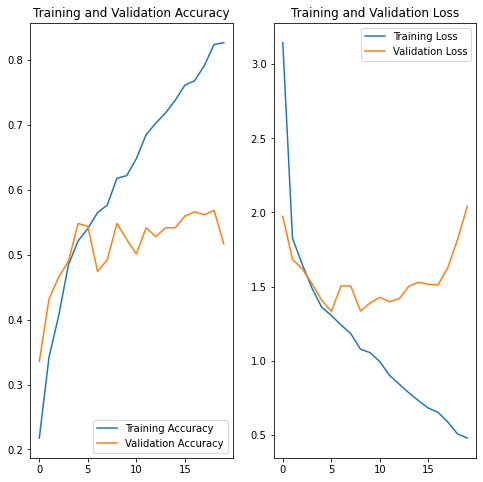

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1.4 Observations

The accuracy of the model for the Training data set is at 78%. But the Validation accuracy is not in par with the training accuracy.
It is only at 53%. The validation loss as observed is very high.
This could also be indicative of some Overfit in the model.
We could add some Dropout layers and remove the BatchNormalization layers. And by adding a few more layers, we could improve the accuracy by trying to extract more features.



# **Model 2**

**2.0 Creating the Model**

In [29]:
model_update=Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255., offset=0.0,),         
                             
    Conv2D(32,(3,3),input_shape=(img_height,img_width,3),activation='relu',padding='same'),
    Conv2D(32,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.7),
    
    Conv2D(64,(3,3),activation='relu',padding='same'),
    Conv2D(64,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.7),
    
    Conv2D(128,(3,3),activation='relu',padding='same'),
    Conv2D(128,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.7),
    
    Flatten(),
    Dense(100, activation='relu'),
    Dropout(0.25),   
    Dense(9, activation='softmax')
])

**2.1 Compiling the model**

In [30]:
model_update.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics='accuracy')

**2.2 Training the model**

In [31]:
epochs = 20
history = model_update.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 236s 4s/step - loss: 2.2553 - accuracy: 0.1875 - val_loss: 2.0797 - val_accuracy: 0.2058
Epoch 2/20
56/56 [==============================] - 236s 4s/step - loss: 2.0381 - accuracy: 0.1948 - val_loss: 2.0458 - val_accuracy: 0.2058
Epoch 3/20
56/56 [==============================] - 237s 4s/step - loss: 2.0354 - accuracy: 0.1931 - val_loss: 2.0324 - val_accuracy: 0.2058
Epoch 4/20
56/56 [==============================] - 235s 4s/step - loss: 2.0325 - accuracy: 0.1892 - val_loss: 2.0367 - val_accuracy: 0.2058
Epoch 5/20
56/56 [==============================] - 234s 4s/step - loss: 2.0280 - accuracy: 0.1914 - val_loss: 2.0229 - val_accuracy: 0.2058
Epoch 6/20
56/56 [==============================] - 237s 4s/step - loss: 2.0250 - accuracy: 0.2037 - val_loss: 2.0132 - val_accuracy: 0.3535
Epoch 7/20
56/56 [==============================] - 235s 4s/step - loss: 1.9506 - accuracy: 0.2539 - val_loss: 1.9847 - val_accuracy: 0.2260
Epoch 8/20
56

**2.3 Visualizing the results** 

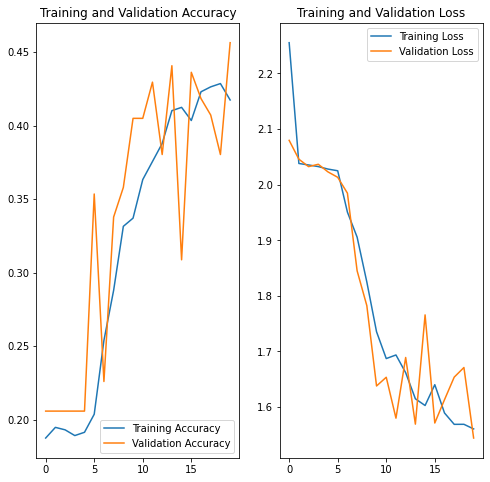

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**2.4 Observations** 

In [33]:
#The model accuracy for Train data set has dropped to nearly 45%.
#The accuracy for the Validation set is at 40%.
#This is a much better model compared to the previous model as there seems to be No Overfit with the training accuracy 45% and validation accuracy at 40%.